In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.rotate(img, -90)),
    transforms.Lambda(lambda img: transforms.functional.hflip(img)),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))
])
train_set = EMNIST(root='./data', split='byclass', train=True, download=True, transform=transform)
test_set = EMNIST(root='./data', split='byclass', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
test
num_classes = 62

In [4]:
sample_img, _ = train_set[0]
print(sample_img.shape)

torch.Size([3, 224, 224])


In [5]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\Sankara\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sankara\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
epochs = 5
train_losses = []

In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")

In [3]:
plt.plot(train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

In [12]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")



Test Accuracy: 85.44%


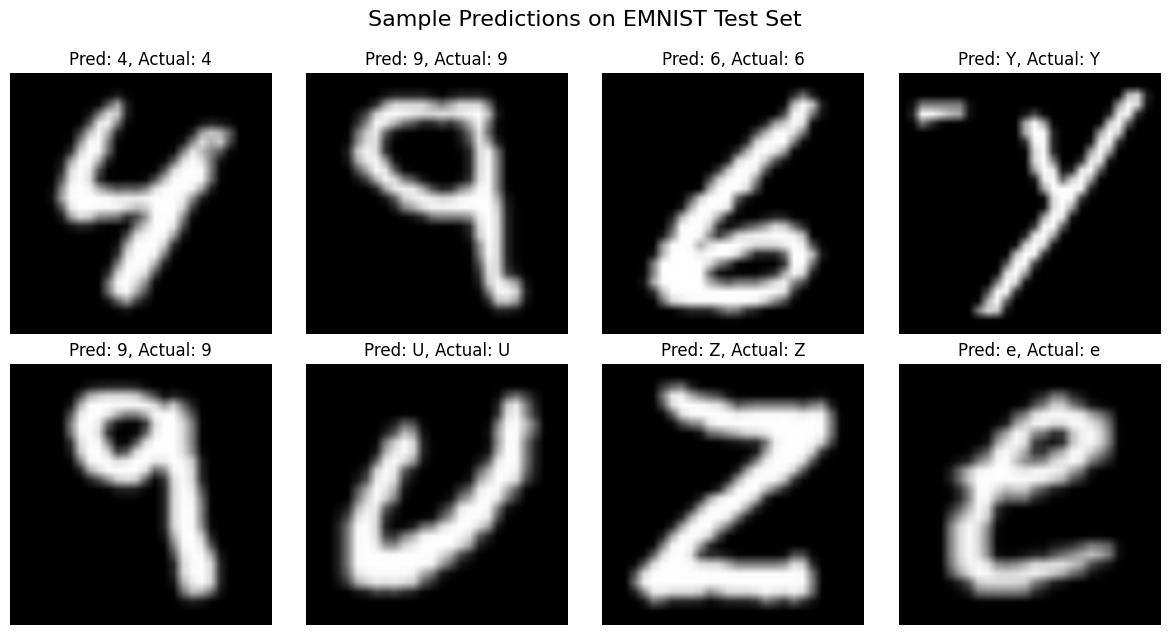

In [11]:
import random

# Set model to evaluation mode
model.eval()

# Pick 8 random test indices
indices = random.sample(range(len(test_set)), 8)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for ax, idx in zip(axes.flat, indices):
    img, label = test_set[idx]
    
    # Preprocess: reshape to batch and send to device
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).item()

    # Convert image back to CPU numpy for display
    img_disp = img.permute(1, 2, 0).cpu().numpy()
    img_disp = (img_disp * 0.5 + 0.5).clip(0, 1)  # De-normalize

    ax.imshow(img_disp.squeeze(), cmap='gray')
    actual_char = test_set.classes[label]
    pred_char = test_set.classes[pred]
    ax.set_title(f"Pred: {pred_char}, Actual: {actual_char}")
    ax.axis('off')

plt.tight_layout()
plt.suptitle("Sample Predictions on EMNIST Test Set", fontsize=16, y=1.05)
plt.show()

In [8]:
from pathlib import Path
ModelPath = Path("models")
ModelPath.mkdir(parents= True,exist_ok= True)

ModelName = "resnet18.pth"
ModelSavePath = ModelPath / ModelName   
ModelSavePath

WindowsPath('models/resnet18.pth')

In [38]:
torch.save(obj=model.state_dict(),f = ModelSavePath)

In [9]:
model.load_state_dict(torch.load(ModelSavePath))

<All keys matched successfully>